# Analysis of 4% Rule in indian context
Check the article https://boringfinance.wordpress.com/2020/06/02/can-investments-take-care-of-your-retirement/ for more detailed explanation


In [1]:
# Analysis of Retirement with Mutual Funds
# Analysis period from 2000 Jan to 2020 May

#Importing libraries
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library

In [2]:
# install xlrd to read spreadsheets
!pip install xlrd
import xlrd
print('xlrd installed!')

xlrd installed!


# Reading Data
Prepared a spreadsheet with historic performance of a liquid fund and an equity fund. This is loaded into pandas for analysis

In [3]:
# reading excel file into data frame
df_data = pd.read_excel('nav_history.xlsx',
                       sheet_name='Sheet1')

print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [4]:
# checking data frame
df_data.head()

,Date,Liquid Fund – NAV,Equity Fund – NAV
0,"Jan 03, 2000",12.760,24.91
1,"Feb 01, 2000",12.930,25.57
2,"Mar 01, 2000",13.120,27.74
3,"Apr 03, 2000",13.224,24.13
4,"May 02, 2000",13.330,20.78


In [5]:
# view df details
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               245 non-null    object 
 1   Liquid Fund – NAV  245 non-null    float64
 2   Equity Fund – NAV  245 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.9+ KB


# Building a Retirement Portfolio
A retirement portfolio is constructed with 2 elements  
1. Growth element, here Equity fund  
2. Income element, here Liquid fund  
  
**The objectives are**:
1. There should be an adequate amount in the buffer so that monthly income is not severely affected by any shocks in the equity market.  
2. Watch for growth in retirement income; whether it keeps up with the rate of inflation.  

4% Rule is a famous retirement strategy, where an individual can build a retirement portfolio and withdraw 4% of it every year, without worrying about running out of money. We are going to build a retirement portfolio based on this with equity and liquid mutual funds and backtest it for the last 20+ years (2000 Jan to 2020 May)

**Key characteristics of the sample retirement portfolio**:

1. Initial yearly withdrawal is 4% of invested capital: solving the numbers, this turns out to be 300x; i.e, for every ₹300 invested, we can safely withdraw ₹1 every month.
2. Initial buffer is set to 10 years worth of expense calculated as on initial day: this means for withdrawal of ₹1 at initial month, ₹120 should be kept as a buffer (in the liquid fund); balance ₹180 is invested into equity.
3. Initial Equity to Debt ratio is set as 60-40: 4% withdrawal and 10 Years of expense implies equity to debt ratio should be 60-40
4. Monthly withdrawal is done from Debt fund and portfolio is rebalanced once in a year: because of regular withdrawal from Debt and market movements in Equity, our intended asset allocation may vary in time. The current asset allocation of the whole portfolio is evaluated once a year.
5. Excess equity (above 60%) will be moved to Debt (Liquid) fund, however at no point, assets will be moved from Liquid fund to Equity fund*6 as it may cause heavy drop in retirement income
6. At assumed 7% inflation, ₹50k as of 2020 is approximately equal to ₹13k in 2000. If we design the portfolio to generate ₹13k monthly in the year 2000 and let it figure out possible monthly withdrawals for each year thereafter, if it results in a monthly withdrawal of more than ₹50k by the year 2020, the portfolio has managed to increment the retirement income at a rate above inflation.
7. Initial retirement portfolio value is set to ₹39 Lakhs (point 1 above; 300 times ₹13k)

In [6]:
# Initial monthly income at 2000 Jan 1 is set to ₹13,000. Reason: at 7% inflation, ₹13,000 ~ ₹50,000 as on 2020
# Initial investment is set so that total withdrawal per year is 4% of capital. in this case ₹39 Lakhs
# Asset allocation is set to 60% Equity and 40% Debt

init_inv=3900000 # initial capital
init_eq_per=0.6
init_eq=init_inv*init_eq_per
init_dt=init_inv-init_eq

monthly_income=[] # creating a list for storing monthy income for every year
retirement_portfolio=[] # creating a list for storing retirement portfolio valuation every year
year=[] # creating a list for year value
year_num=0 # to track year in progress
monthly_income.append(13000) # initial monthly withdrawal
retirement_portfolio.append(init_inv) # initial portfolio valuation
year.append(2000) # initial year is 2000

In [7]:

# adding 6 new empty columns
df_data['Liquid fund – Units']=""
df_data['Equity fund – Units']=""
df_data['Redemption']=""
df_data['Liquid fund – Value']=""
df_data['Equity fund – Value']=""
df_data['Equity percent']=""

#initializing first row
df_data.loc[0,'Liquid fund – Units']=(init_dt-monthly_income[year_num])/df_data.loc[0,'Liquid Fund – NAV']
df_data.loc[0,'Equity fund – Units']=init_eq/df_data.loc[0,'Equity Fund – NAV']
df_data.loc[0,'Redemption']=monthly_income[year_num]
df_data.loc[0,'Liquid fund – Value']=df_data.loc[0,'Liquid fund – Units']*df_data.loc[0,'Liquid Fund – NAV']
df_data.loc[0,'Equity fund – Value']=df_data.loc[0,'Equity fund – Units']*df_data.loc[0,'Equity Fund – NAV']
df_data.loc[0,'Equity percent']=(100*df_data.loc[0,'Equity fund – Value'])/(df_data.loc[0,'Equity fund – Value']+df_data.loc[0,'Liquid fund – Value'])

# number of rows
var_rows=len(df_data.index)

for i in range(1,var_rows):
    if(i%12==0): # when 1 year is completed, asset rebalance is triggered
        year_num+=1 # incrementing year number
        year.append(2000+year_num)
        # calculating asset allocation before redemption and rebalancing
        df_data.loc[i,'Liquid fund – Units']=df_data.loc[i-1,'Liquid fund – Units']
        df_data.loc[i,'Equity fund – Units']=df_data.loc[i-1,'Equity fund – Units']
        df_data.loc[i,'Liquid fund – Value']=df_data.loc[i,'Liquid fund – Units']*df_data.loc[i,'Liquid Fund – NAV']
        df_data.loc[i,'Equity fund – Value']=df_data.loc[i,'Equity fund – Units']*df_data.loc[i,'Equity Fund – NAV']
        total_value=df_data.loc[i,'Liquid fund – Value']+df_data.loc[i,'Equity fund – Value']
        df_data.loc[i,'Equity percent']=(100*df_data.loc[i,'Equity fund – Value'])/total_value
        retirement_portfolio.append(total_value) # storing portfolio valuation yearly during rebalancing
        # if equity exceeds 60%
        if(df_data.loc[i,'Equity percent']>60):
            # equity is above 60%, moving excess equity asset into liquid fund to bring back asset allocation to 60:40
            excess_equity=df_data.loc[i,'Equity fund – Value']-(0.6*total_value)
            df_data.loc[i,'Liquid fund – Units']=df_data.loc[i,'Liquid fund – Units']+(excess_equity/df_data.loc[i,'Liquid Fund – NAV'])
            df_data.loc[i,'Equity fund – Units']=df_data.loc[i,'Equity fund – Units']-(excess_equity/df_data.loc[i,'Equity Fund – NAV'])
            df_data.loc[i,'Liquid fund – Value']=df_data.loc[i,'Liquid fund – Units']*df_data.loc[i,'Liquid Fund – NAV']
            df_data.loc[i,'Equity fund – Value']=df_data.loc[i,'Equity fund – Units']*df_data.loc[i,'Equity Fund – NAV']
        # Finding new monthly withdrawal
        monthly_income.append(df_data.loc[i,'Liquid fund – Value']/120) # 10% of liquid fund value is redeemed an year
        df_data.loc[i,'Redemption']=monthly_income[year_num]
        # recording updated liquid fund units, value and equity percentage after 1 month withdrawal
        df_data.loc[i,'Liquid fund – Units']=df_data.loc[i,'Liquid fund – Units']-(monthly_income[year_num]/df_data.loc[i,'Liquid Fund – NAV'])
        df_data.loc[i,'Liquid fund – Value']=df_data.loc[i,'Liquid fund – Units']*df_data.loc[i,'Liquid Fund – NAV']
        df_data.loc[i,'Equity percent']=(100*df_data.loc[i,'Equity fund – Value'])/(df_data.loc[i,'Equity fund – Value']+df_data.loc[i,'Liquid fund – Value'])
        
    else:
        # months without rebalacing. only redemption from liquid funds is carried out
        df_data.loc[i,'Liquid fund – Units']=df_data.loc[i-1,'Liquid fund – Units']-(monthly_income[year_num]/df_data.loc[i,'Liquid Fund – NAV'])
        df_data.loc[i,'Equity fund – Units']=df_data.loc[i-1,'Equity fund – Units']
        df_data.loc[i,'Redemption']=monthly_income[year_num]
        df_data.loc[i,'Liquid fund – Value']=df_data.loc[i,'Liquid fund – Units']*df_data.loc[i,'Liquid Fund – NAV']
        df_data.loc[i,'Equity fund – Value']=df_data.loc[i,'Equity fund – Units']*df_data.loc[i,'Equity Fund – NAV']
        df_data.loc[i,'Equity percent']=(100*df_data.loc[i,'Equity fund – Value'])/(df_data.loc[i,'Equity fund – Value']+df_data.loc[i,'Liquid fund – Value'])
    #end else
#end for

In [8]:
# import required libraries for graph plot
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
print ('Matplotlib version: ', mpl.__version__ )

# choosing plot style
print(plt.style.available)
mpl.style.use(['ggplot'])


Matplotlib version:  3.3.2
['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


# Plotting performance of Liquid fund
The performance of a sample Liquid Fund for past 20+ years

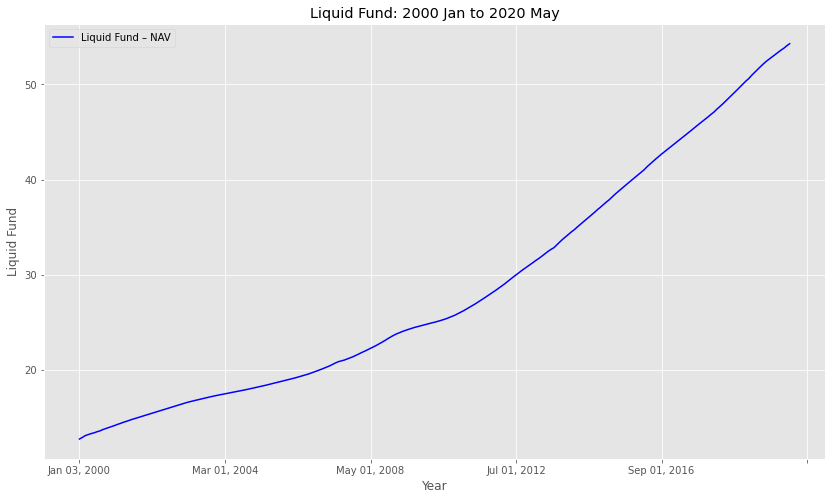

In [9]:
# Graph to plot liquid fund NAV

# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf=df_data[['Date','Liquid Fund – NAV']]

# plotting the line chart with 'Date' as X axis
graphdf.set_index('Date').plot(kind='line',figsize=(14,8),color='blue')
plt.title('Liquid Fund: 2000 Jan to 2020 May')
plt.xlabel('Year')
plt.ylabel('Liquid Fund')
plt.savefig('pic01.png')
plt.show()

**Observations**:
1. There was no visible volatility in the long term chart.
2. The yearly growth of this Liquid fund was 7.38% during the period.  

Even though the fund chart looks perfect, the return is very less compared to the equity fund. India’s long term inflation is around 7%. At 7.38%, the fund is giving very low real returns (return more than inflation)

# Plotting performance of Equity fund
A sample Equity fund performance for the past 20+ years

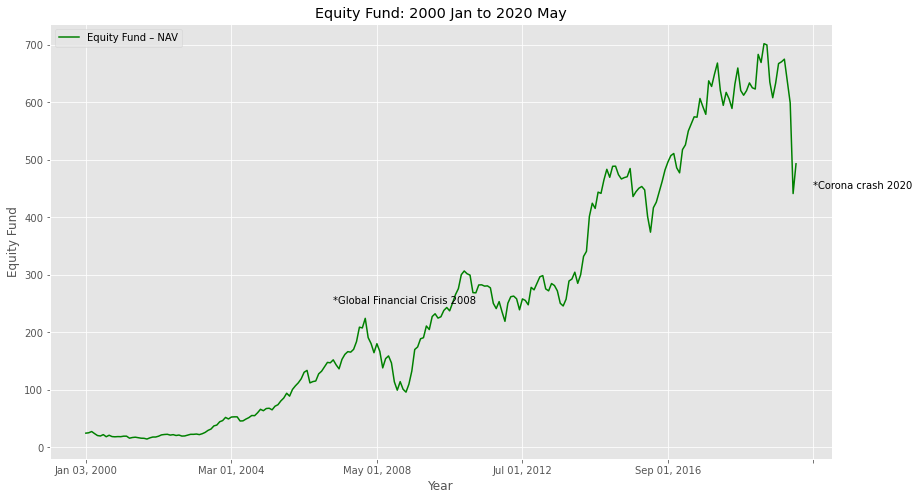

In [10]:
# Graph to plot Equity fund NAV

# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf=df_data[['Date','Equity Fund – NAV']]

# plotting the line chart with 'Date' as X axis
graphdf.set_index('Date').plot(kind='line',figsize=(14,8),color='green')
plt.title('Equity Fund: 2000 Jan to 2020 May')
plt.xlabel('Year')
plt.ylabel('Equity Fund')
plt.text(85,250,'*Global Financial Crisis 2008')
plt.text(250,450,'*Corona crash 2020')
plt.savefig('pic02.png')
plt.show()

**Observations**:

1. The fund is very volatile
2. Yearly growth of this Equity fund was 15.82% during the period
3. During the Global Finance crisis 2008-09, the fund lost 57.1% of its value from its peak*5
4. In the first 3 months of 2020, the fund lost 34.6%*5  

Even though the fund has given impressive returns for the whole period, the return is very uneven, making it difficult to be used as a sole retirement fund
  
On the other hand, Even though the liquid fund chart looks good, the return is very less compared to the equity fund. India’s long term inflation is around 7%. At 7.38%, the liquid fund is giving very low real returns (return more than inflation)

In [11]:
# creating new data frame with year, monthly income and portfolio valuation

df_portfolio = pd.DataFrame(list(zip(year,monthly_income,retirement_portfolio)), columns= ['Year','Monthly Income','Portfolio Value'])

# Plotting valuation of combined portfolio
The combined 60:40, Equity:Liquid portfolio is plotted for 20+ years

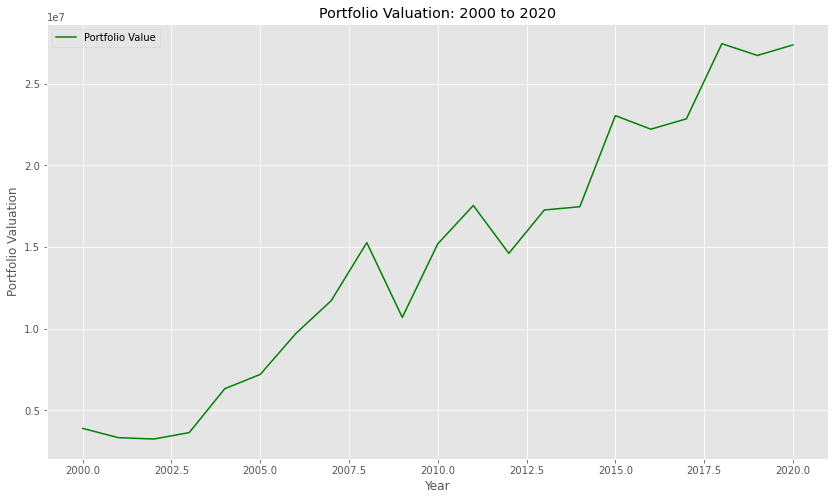

In [12]:
# Graph to plot Portfolio Valuation

# creating new dataframe graphdf with 2 columns Year and Portfolio Valuation
graphdf=df_portfolio[['Year','Portfolio Value']]

# plotting the line chart with 'Year' as X axis
graphdf.set_index('Year').plot(kind='line',figsize=(14,8),color='green')
plt.title('Portfolio Valuation: 2000 to 2020')
plt.xlabel('Year')
plt.ylabel('Portfolio Valuation')
plt.savefig('pic03.png')
plt.show()

**Observations**:
1. The asset allocation has managed to cushion market falls. Even after regular monthly withdrawals at around 4%, portfolio value fell by just 30% in 2008, compared to a 51% fall in the Equity fund.
2. Overall portfolio value has been increasing at 10.23% per year (in addition to ~4% income)

# Plotting Monthly Income
The monthly income generated by the portfolio is plotted for 20+ years

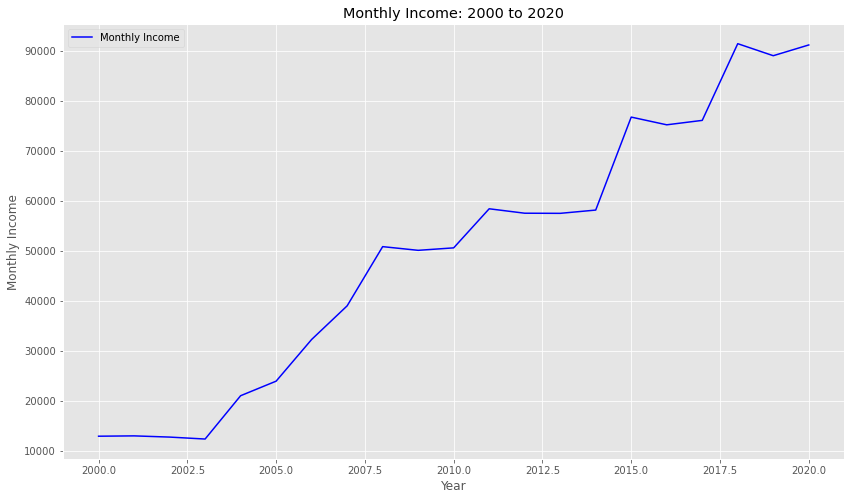

In [13]:
# Graph to plot Monthly income

# creating new dataframe graphdf with 2 columns Year and Monthly income
graphdf=df_portfolio[['Year','Monthly Income']]

# plotting the line chart with 'Year' as X axis
graphdf.set_index('Year').plot(kind='line',figsize=(14,8),color='blue')
plt.title('Monthly Income: 2000 to 2020')
plt.xlabel('Year')
plt.ylabel('Monthly Income')
plt.savefig('pic04.png')
plt.show()

**Observations**:
1. The Liquid fund has helped in limiting dips in income. The biggest yearly dip in income was 3.04% compared to the biggest yearly loss of 52% for Equity fund and 30% for portfolio valuation.
2. Income has been increasing at the rate of 10.23% per year for the whole period, beating the long-term inflation rate of 7%
3. The rate of increase was not uniform, 7 out of 20 years, income went down, ranging from -3.04% to -0.04%
4. 13 out of 20 years, income went up, ranging from 0.51% to 69.65%

# Recording values
The below code will generate a spreadsheet with portfilio valuation and monthly income for the period 2000-2020

In [14]:
# writing portfolio and monthly income to output excel file

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('output_file.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df_portfolio.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()